Cargando modelo...
Inicializando modelo...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_4']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


✓ Modelo inicializado

--- Identificando capas ---
✓ Modelo base: vgg16
✓ Última capa convolucional: block5_conv3

Evaluando: /content/good (63).jpg

Generando Grad-CAM++...


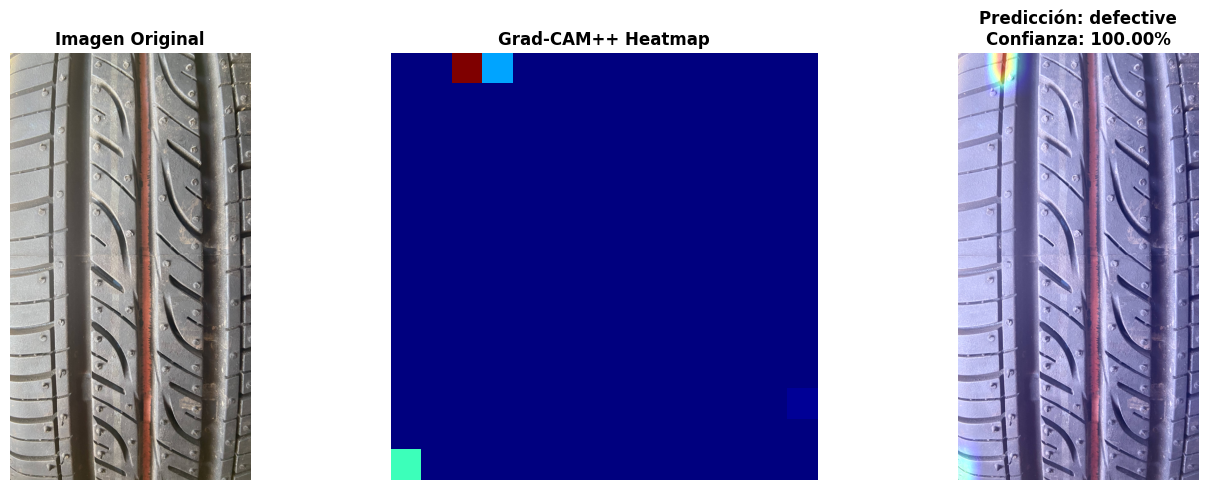


Predicciones:
  good: 0.00%
  defective: 100.00%

Comparación: Activaciones para cada clase



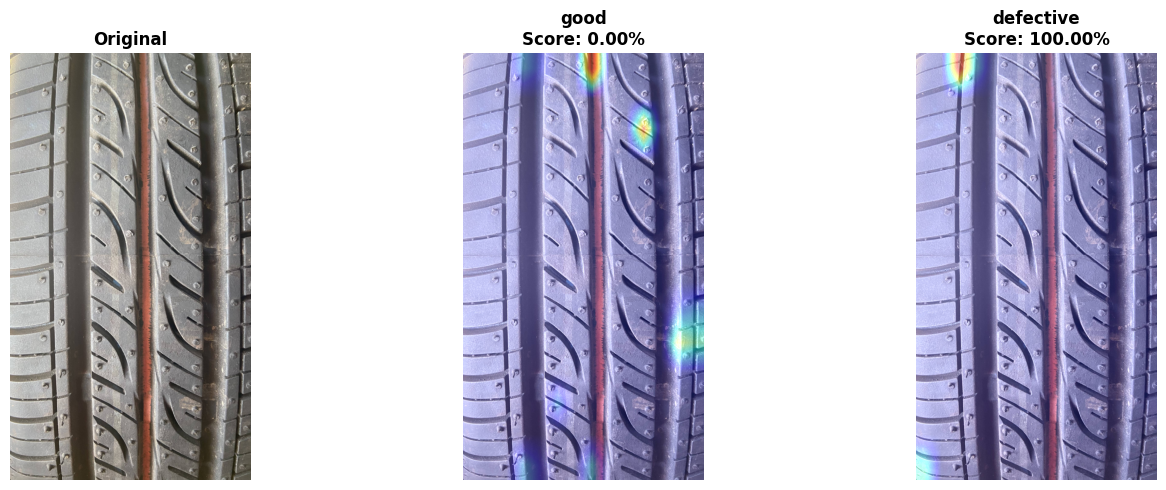


ANÁLISIS DE MÚLTIPLES IMÁGENES

⚠ Agrega más imágenes a la lista 'test_images' para análisis múltiple


In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2

# ===== CONFIGURACIÓN =====
MODEL_PATH = '/content/drive/MyDrive/best_vgg16_v3.keras'
IMG_SIZE = (224, 224)
CLASS_NAMES = ['good', 'defective']

# ===== FUNCIONES AUXILIARES =====

def get_img_array(img_path, size):
    """Carga y preprocesa una imagen"""
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# ===== GRAD-CAM++ =====

def make_gradcam_plusplus_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Genera el heatmap Grad-CAM++

    Mejoras sobre Grad-CAM:
    - Ponderación más inteligente de píxeles
    - Mejor localización de características
    - Mapas de calor más precisos
    """
    # Obtener el modelo base VGG16
    vgg_base = model.get_layer('vgg16')
    last_conv_layer = vgg_base.get_layer(last_conv_layer_name)

    # Calcular gradientes de múltiples órdenes
    with tf.GradientTape(persistent=True) as tape1:
        with tf.GradientTape(persistent=True) as tape2:
            with tf.GradientTape() as tape3:
                # Forward pass para obtener conv outputs
                vgg_output = vgg_base(img_array)

                # Crear sub-modelo para extraer activaciones intermedias
                intermediate_model = keras.Model(
                    inputs=vgg_base.input,
                    outputs=last_conv_layer.output
                )
                conv_outputs = intermediate_model(img_array)
                tape3.watch(conv_outputs)

                # Pasar por el resto del modelo
                x = conv_outputs
                # Global Average Pooling
                x = model.layers[1](x)
                # Dense layers
                for layer in model.layers[2:]:
                    x = layer(x)
                predictions = x

                if pred_index is None:
                    pred_index = tf.argmax(predictions[0])
                class_channel = predictions[:, pred_index]

            # Gradientes de primer orden
            grads = tape3.gradient(class_channel, conv_outputs)

        # Gradientes de segundo orden
        grads_2 = tape2.gradient(grads, conv_outputs)

    # Gradientes de tercer orden
    grads_3 = tape1.gradient(grads_2, conv_outputs)

    # Limpiar tapes
    del tape1, tape2

    # Convertir a numpy
    conv_outputs = conv_outputs[0].numpy()
    grads = grads[0].numpy()
    grads_2 = grads_2[0].numpy()
    grads_3 = grads_3[0].numpy()

    # Calcular pesos alpha (característica clave de Grad-CAM++)
    global_sum = np.sum(conv_outputs, axis=(0, 1), keepdims=True)

    # Evitar división por cero
    alpha_denom = grads_2 * 2.0 + grads_3 * global_sum + 1e-10
    alpha_num = grads_2
    alpha = alpha_num / alpha_denom

    # ReLU en los gradientes
    positive_grads = np.maximum(grads, 0)

    # Ponderación final
    weights = np.sum(alpha * positive_grads, axis=(0, 1))

    # Generar el mapa de calor
    cam = np.zeros(conv_outputs.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]

    # ReLU y normalización
    cam = np.maximum(cam, 0)
    if np.max(cam) != 0:
        cam = cam / np.max(cam)

    return cam, predictions.numpy()

# ===== VISUALIZACIÓN =====

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    """Superpone el heatmap sobre la imagen original"""
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    keras.preprocessing.image.save_img(cam_path, superimposed_img)
    return superimposed_img

def visualize_gradcam_plusplus(img_path, model, last_conv_layer_name, class_names):
    """Visualización completa de Grad-CAM++"""
    # Preprocesar
    img_array = get_img_array(img_path, size=IMG_SIZE)
    img_array = img_array / 255.0  # Normalización

    print("Generando Grad-CAM++...")
    heatmap, preds = make_gradcam_plusplus_heatmap(
        img_array, model, last_conv_layer_name
    )

    cam_img = save_and_display_gradcam(img_path, heatmap)

    pred_class = np.argmax(preds[0])
    confidence = preds[0][pred_class] * 100

    # Visualización
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    original = keras.preprocessing.image.load_img(img_path)
    axes[0].imshow(original)
    axes[0].set_title('Imagen Original', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('Grad-CAM++ Heatmap', fontsize=12, fontweight='bold')
    axes[1].axis('off')

    axes[2].imshow(cam_img)
    axes[2].set_title(
        f'Predicción: {class_names[pred_class]}\n'
        f'Confianza: {confidence:.2f}%',
        fontsize=12,
        fontweight='bold'
    )
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return heatmap, preds

def compare_both_classes(img_path, model, last_conv_layer_name, class_names):
    """Muestra Grad-CAM++ para ambas clases"""
    img_array = get_img_array(img_path, IMG_SIZE) / 255.0

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Imagen original
    original = keras.preprocessing.image.load_img(img_path)
    axes[0].imshow(original)
    axes[0].set_title('Original', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Grad-CAM++ para cada clase
    for idx, class_name in enumerate(class_names):
        heatmap, preds = make_gradcam_plusplus_heatmap(
            img_array, model, last_conv_layer_name, pred_index=idx
        )
        cam_img = save_and_display_gradcam(img_path, heatmap)

        axes[idx+1].imshow(cam_img)
        axes[idx+1].set_title(
            f'{class_name}\nScore: {preds[0][idx]*100:.2f}%',
            fontsize=12,
            fontweight='bold'
        )
        axes[idx+1].axis('off')

    plt.tight_layout()
    plt.show()

# ===== CARGAR Y PREPARAR MODELO =====
print("Cargando modelo...")
model = keras.models.load_model(MODEL_PATH)

# Inicializar modelo
print("Inicializando modelo...")
dummy_input = np.zeros((1, *IMG_SIZE, 3))
_ = model.predict(dummy_input, verbose=0)
print("✓ Modelo inicializado\n")

# Identificar última capa convolucional
print("--- Identificando capas ---")
vgg_base = model.get_layer('vgg16')
print(f"✓ Modelo base: {vgg_base.name}")

last_conv_layer_name = None
for layer in reversed(vgg_base.layers):
    if 'conv' in layer.name.lower():
        last_conv_layer_name = layer.name
        print(f"✓ Última capa convolucional: {last_conv_layer_name}")
        break

if last_conv_layer_name is None:
    raise ValueError("No se encontró capa convolucional")

# ===== EVALUAR IMAGEN =====
IMAGE_PATH = '/content/good (63).jpg'

print(f"\n{'='*60}")
print(f"Evaluando: {IMAGE_PATH}")
print(f"{'='*60}\n")

heatmap, predictions = visualize_gradcam_plusplus(
    IMAGE_PATH,
    model,
    last_conv_layer_name,
    CLASS_NAMES
)

print("\nPredicciones:")
for i, class_name in enumerate(CLASS_NAMES):
    print(f"  {class_name}: {predictions[0][i]*100:.2f}%")

# ===== COMPARAR AMBAS CLASES =====
print(f"\n{'='*60}")
print("Comparación: Activaciones para cada clase")
print(f"{'='*60}\n")

compare_both_classes(IMAGE_PATH, model, last_conv_layer_name, CLASS_NAMES)

# ===== COMPARAR MÚLTIPLES IMÁGENES =====

def compare_multiple_images(image_paths, model, last_conv_layer_name, class_names, cols=3):
    """
    Compara Grad-CAM++ para múltiples imágenes en una cuadrícula

    Args:
        image_paths: lista de rutas de imágenes
        model: modelo cargado
        last_conv_layer_name: nombre de última capa conv
        class_names: nombres de clases
        cols: número de columnas en la cuadrícula
    """
    n_images = len(image_paths)
    rows = (n_images + cols - 1) // cols  # redondear hacia arriba

    fig, axes = plt.subplots(rows, cols * 2, figsize=(cols * 6, rows * 3))

    # Aplanar axes si es necesario
    if rows == 1:
        axes = axes.reshape(1, -1)

    for idx, img_path in enumerate(image_paths):
        row = idx // cols
        col_offset = (idx % cols) * 2

        # Procesar imagen
        img_array = get_img_array(img_path, IMG_SIZE) / 255.0
        heatmap, preds = make_gradcam_plusplus_heatmap(
            img_array, model, last_conv_layer_name
        )
        cam_img = save_and_display_gradcam(img_path, heatmap)

        pred_class = np.argmax(preds[0])
        confidence = preds[0][pred_class] * 100

        # Imagen original
        original = keras.preprocessing.image.load_img(img_path)
        axes[row, col_offset].imshow(original)
        axes[row, col_offset].set_title(
            f'Original\n{class_names[pred_class]} ({confidence:.1f}%)',
            fontsize=10
        )
        axes[row, col_offset].axis('off')

        # Grad-CAM++
        axes[row, col_offset + 1].imshow(cam_img)
        axes[row, col_offset + 1].set_title('Grad-CAM++', fontsize=10)
        axes[row, col_offset + 1].axis('off')

    # Ocultar ejes vacíos
    for idx in range(n_images, rows * cols):
        row = idx // cols
        col_offset = (idx % cols) * 2
        axes[row, col_offset].axis('off')
        axes[row, col_offset + 1].axis('off')

    plt.tight_layout()
    plt.show()

def analyze_batch(image_paths, model, last_conv_layer_name, class_names):
    """
    Análisis detallado de un lote de imágenes con estadísticas
    """
    results = []

    print(f"Analizando {len(image_paths)} imágenes...\n")

    for i, img_path in enumerate(image_paths, 1):
        img_array = get_img_array(img_path, IMG_SIZE) / 255.0
        heatmap, preds = make_gradcam_plusplus_heatmap(
            img_array, model, last_conv_layer_name
        )

        pred_class = np.argmax(preds[0])
        confidence = preds[0][pred_class] * 100

        result = {
            'path': img_path,
            'filename': img_path.split('/')[-1],
            'predicted_class': class_names[pred_class],
            'confidence': confidence,
            'good_score': preds[0][0] * 100,
            'defective_score': preds[0][1] * 100,
            'heatmap': heatmap
        }
        results.append(result)

        print(f"{i}. {result['filename']}")
        print(f"   Predicción: {result['predicted_class']} ({confidence:.2f}%)")
        print(f"   Scores - Good: {result['good_score']:.2f}% | Defective: {result['defective_score']:.2f}%\n")

    return results

def create_summary_report(results, class_names):
    """Crea un reporte visual con estadísticas"""
    # Calcular estadísticas
    predictions = [r['predicted_class'] for r in results]
    confidences = [r['confidence'] for r in results]

    good_count = predictions.count('good')
    defective_count = predictions.count('defective')
    avg_confidence = np.mean(confidences)

    # Crear figura con múltiples subplots
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

    # 1. Distribución de predicciones (gráfico de barras)
    ax1 = fig.add_subplot(gs[0, :2])
    counts = [good_count, defective_count]
    colors = ['#2ecc71', '#e74c3c']
    bars = ax1.bar(class_names, counts, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Cantidad', fontsize=12)
    ax1.set_title('Distribución de Predicciones', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)

    # Agregar valores en las barras
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

    # 2. Distribución de confianza (histograma)
    ax2 = fig.add_subplot(gs[0, 2:])
    ax2.hist(confidences, bins=10, color='#3498db', alpha=0.7, edgecolor='black')
    ax2.axvline(avg_confidence, color='red', linestyle='--', linewidth=2, label=f'Promedio: {avg_confidence:.1f}%')
    ax2.set_xlabel('Confianza (%)', fontsize=12)
    ax2.set_ylabel('Frecuencia', fontsize=12)
    ax2.set_title('Distribución de Confianza', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # 3. Top 3 más confiables
    ax3 = fig.add_subplot(gs[1, :])
    top_results = sorted(results, key=lambda x: x['confidence'], reverse=True)[:min(3, len(results))]

    for i, result in enumerate(top_results):
        img = keras.preprocessing.image.load_img(result['path'], target_size=IMG_SIZE)
        img_array = keras.preprocessing.image.img_to_array(img) / 255.0

        ax_img = plt.subplot(gs[1, i])
        ax_img.imshow(img)
        color = '#2ecc71' if result['predicted_class'] == 'good' else '#e74c3c'
        ax_img.set_title(
            f"{result['filename']}\n{result['predicted_class']}: {result['confidence']:.1f}%",
            fontsize=10,
            color=color,
            fontweight='bold'
        )
        ax_img.axis('off')

    # 4. Heatmaps promedio por clase
    good_heatmaps = [r['heatmap'] for r in results if r['predicted_class'] == 'good']
    defective_heatmaps = [r['heatmap'] for r in results if r['predicted_class'] == 'defective']

    if good_heatmaps:
        avg_good_heatmap = np.mean(good_heatmaps, axis=0)
        ax4 = fig.add_subplot(gs[2, :2])
        im1 = ax4.imshow(avg_good_heatmap, cmap='jet')
        ax4.set_title('Heatmap Promedio: GOOD', fontsize=12, fontweight='bold')
        ax4.axis('off')
        plt.colorbar(im1, ax=ax4, fraction=0.046)

    if defective_heatmaps:
        avg_defective_heatmap = np.mean(defective_heatmaps, axis=0)
        ax5 = fig.add_subplot(gs[2, 2:])
        im2 = ax5.imshow(avg_defective_heatmap, cmap='jet')
        ax5.set_title('Heatmap Promedio: DEFECTIVE', fontsize=12, fontweight='bold')
        ax5.axis('off')
        plt.colorbar(im2, ax=ax5, fraction=0.046)

    # Título general
    fig.suptitle(
        f'Reporte de Análisis - {len(results)} Imágenes\n'
        f'Good: {good_count} | Defective: {defective_count} | Confianza Promedio: {avg_confidence:.1f}%',
        fontsize=16,
        fontweight='bold',
        y=0.98
    )

    plt.show()

    return {
        'total': len(results),
        'good': good_count,
        'defective': defective_count,
        'avg_confidence': avg_confidence
    }

# ===== EJEMPLO DE USO: MÚLTIPLES IMÁGENES =====

# Opción 1: Lista manual de imágenes
test_images = [
    '/content/good (63).jpg'

    # Agrega más rutas aquí
]

# Opción 2: Cargar todas las imágenes de una carpeta
import glob
# test_images = glob.glob('/content/*.jpg')[:10]  # Primeras 10 imágenes

# Opción 3: Filtrar por tipo
# good_images = glob.glob('/content/good/*.jpg')
# defective_images = glob.glob('/content/defective/*.jpg')
# test_images = good_images[:5] + defective_images[:5]

print(f"\n{'='*60}")
print("ANÁLISIS DE MÚLTIPLES IMÁGENES")
print(f"{'='*60}\n")

if len(test_images) > 1:
    # Comparación visual en cuadrícula
    print("Generando comparación visual...\n")
    compare_multiple_images(test_images, model, last_conv_layer_name, CLASS_NAMES, cols=3)

    # Análisis detallado con estadísticas
    results = analyze_batch(test_images, model, last_conv_layer_name, CLASS_NAMES)

    # Reporte visual con gráficos
    print(f"\n{'='*60}")
    print("REPORTE ESTADÍSTICO")
    print(f"{'='*60}\n")
    stats = create_summary_report(results, CLASS_NAMES)

    print(f"\nResumen:")
    print(f"  Total de imágenes: {stats['total']}")
    print(f"  Good: {stats['good']} ({stats['good']/stats['total']*100:.1f}%)")
    print(f"  Defective: {stats['defective']} ({stats['defective']/stats['total']*100:.1f}%)")
    print(f"  Confianza promedio: {stats['avg_confidence']:.2f}%")
else:
    print("⚠ Agrega más imágenes a la lista 'test_images' para análisis múltiple")